# Где дешевле жить? Предсказание цен в Airbnb

В этом проекте мы будем строить интерпретируемые модели линейной регрессии для предсказания цен на жилье в Airbnb в Нью-Йорке. Мы пройдем через следующие этапы:
1. EDA (Exploratory Data Analysis)
2. Preprocessing & Feature Engineering
3. Modeling

## Опробованные методики и их результаты

| Методика | Результат |
|----------|----------|
| Удаление ненужных признаков | Помогло уменьшить размерность данных |
| One-hot encoding для категориальных переменных | Помогло улучшить качество модели |
| Обработка выбросов в цене | Значительно улучшило качество модели |
| Логарифмирование целевой переменной | Существенно улучшило качество модели |
| Создание признака расстояния до центра Манхэттена | Помогло улучшить качество модели |
| Создание признаков на основе neighbourhood | Помогло улучшить качество модели |
| Стандартизация числовых признаков | Помогло для регуляризованных моделей |
| Применение регуляризации (Ridge, Lasso, ElasticNet) | Ridge показал лучшие результаты |

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)
sns.set_theme("notebook")

In [2]:
# Загрузка данных
raw_data = pd.read_csv('AB_NYC_2019.csv')
print(f"Размер датасета: {raw_data.shape}")
raw_data.head()

Размер датасета: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Часть 1: EDA (Exploratory Data Analysis)

In [3]:
# Базовая информация о датасете
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [4]:
# Статистическое описание числовых признаков
raw_data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [5]:
# Проверка пропущенных значений
missing_values = raw_data.isnull().sum()
missing_percentage = (missing_values / len(raw_data)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percentage
name,16,0.032723
host_name,21,0.042949
last_review,10052,20.558339
reviews_per_month,10052,20.558339


In [6]:
# Удаление ненужных признаков: id, name, host_id, host_name, last_review
data = raw_data.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


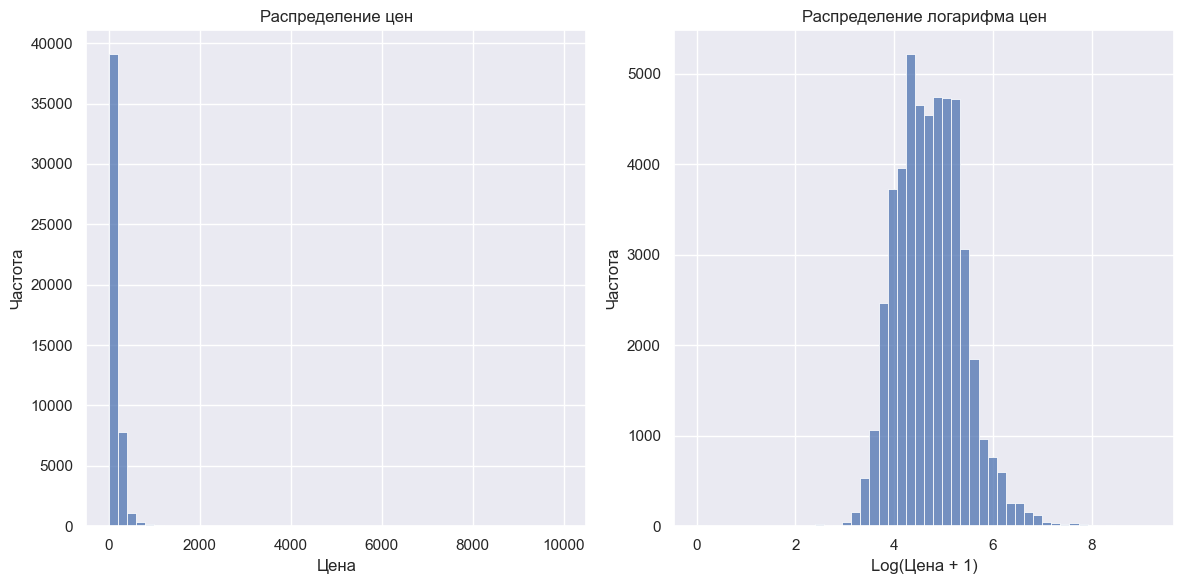

In [7]:
# Распределение целевой переменной (price)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['price'], bins=50)
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(data['price']), bins=50)
plt.title('Распределение логарифма цен')
plt.xlabel('Log(Цена + 1)')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

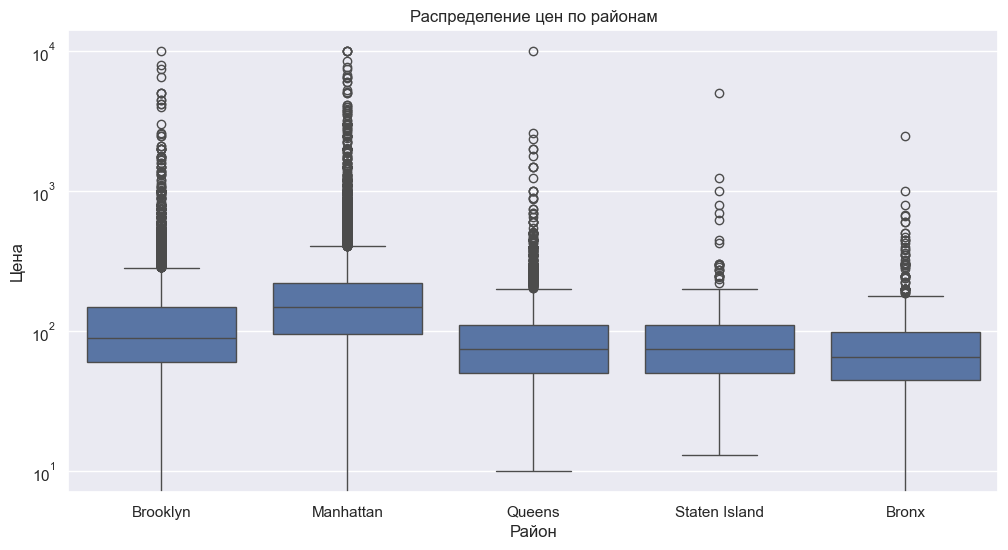

In [8]:
# Распределение цен по районам (neighbourhood_group)
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood_group', y='price', data=data)
plt.title('Распределение цен по районам')
plt.xlabel('Район')
plt.ylabel('Цена')
plt.yscale('log')
plt.show()

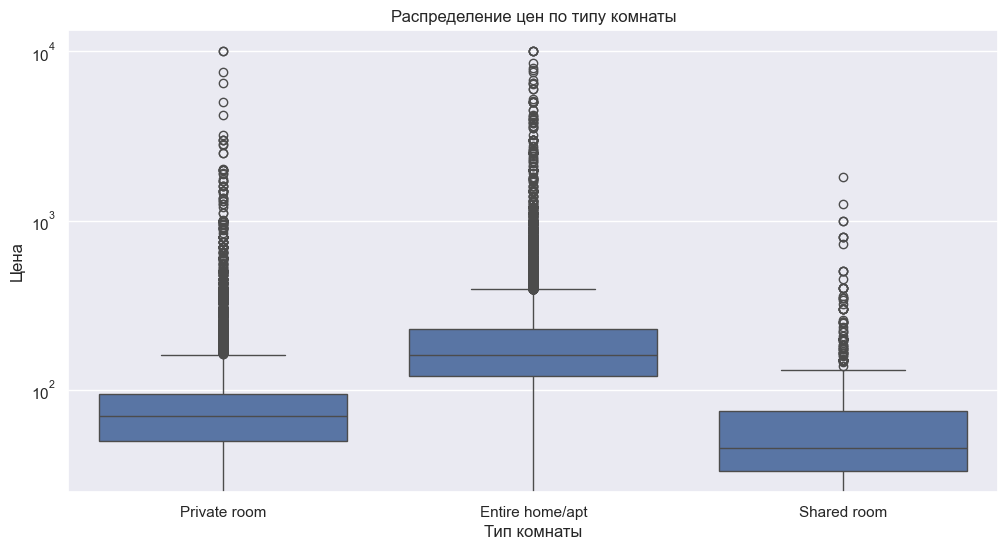

In [9]:
# Распределение цен по типу комнаты (room_type)
plt.figure(figsize=(12, 6))
sns.boxplot(x='room_type', y='price', data=data)
plt.title('Распределение цен по типу комнаты')
plt.xlabel('Тип комнаты')
plt.ylabel('Цена')
plt.yscale('log')
plt.show()

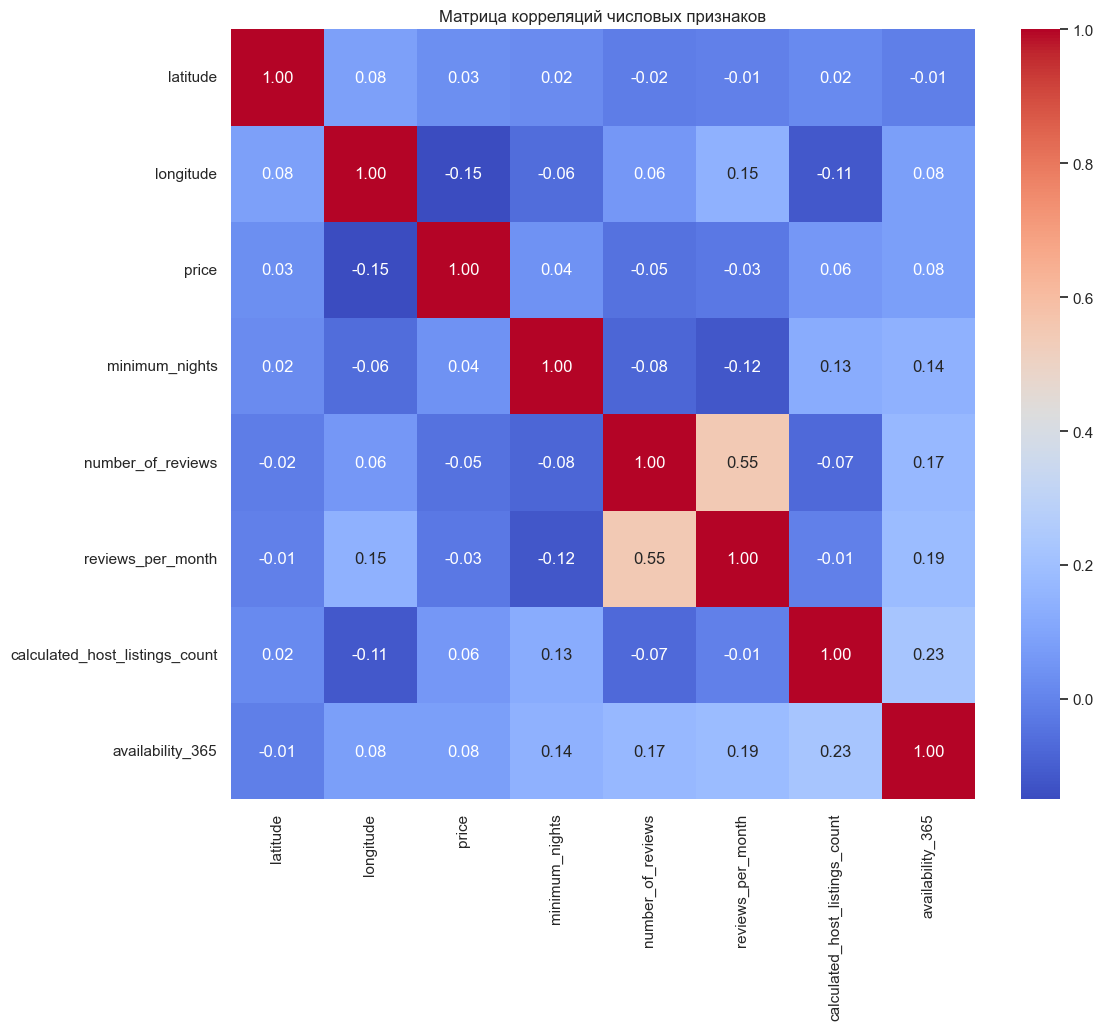

In [10]:
# Матрица корреляций для числовых признаков
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций числовых признаков')
plt.show()

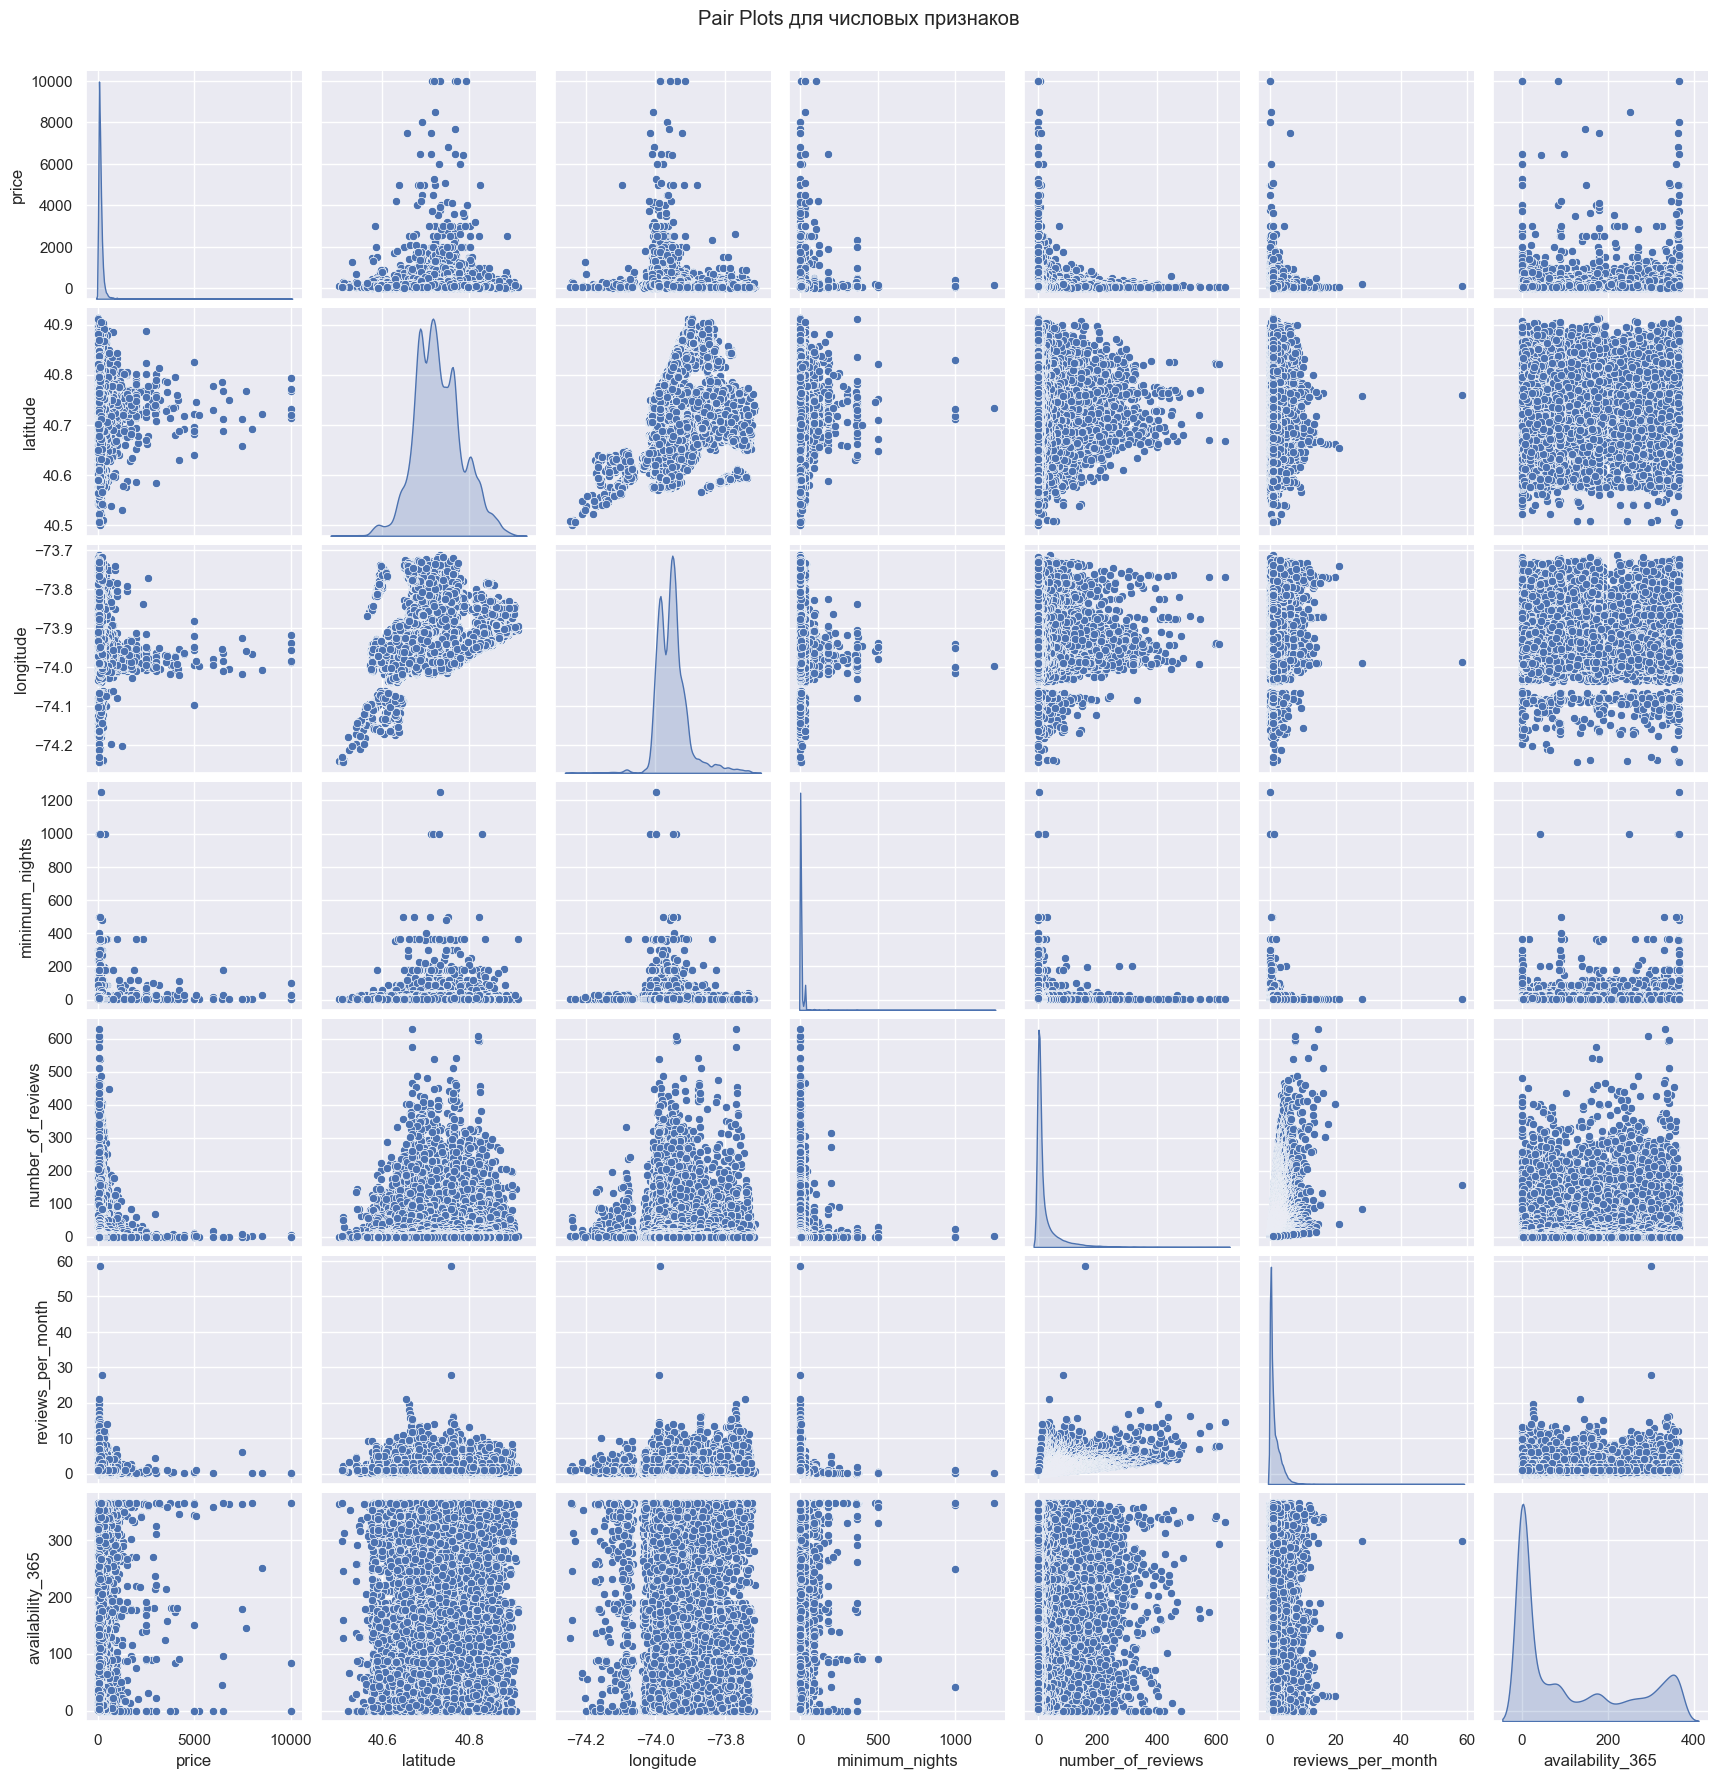

In [11]:
# Pair plots для некоторых числовых признаков
selected_numeric_cols = ['price', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
sns.pairplot(data[selected_numeric_cols], diag_kind='kde')
plt.suptitle('Pair Plots для числовых признаков', y=1.02)
plt.show()

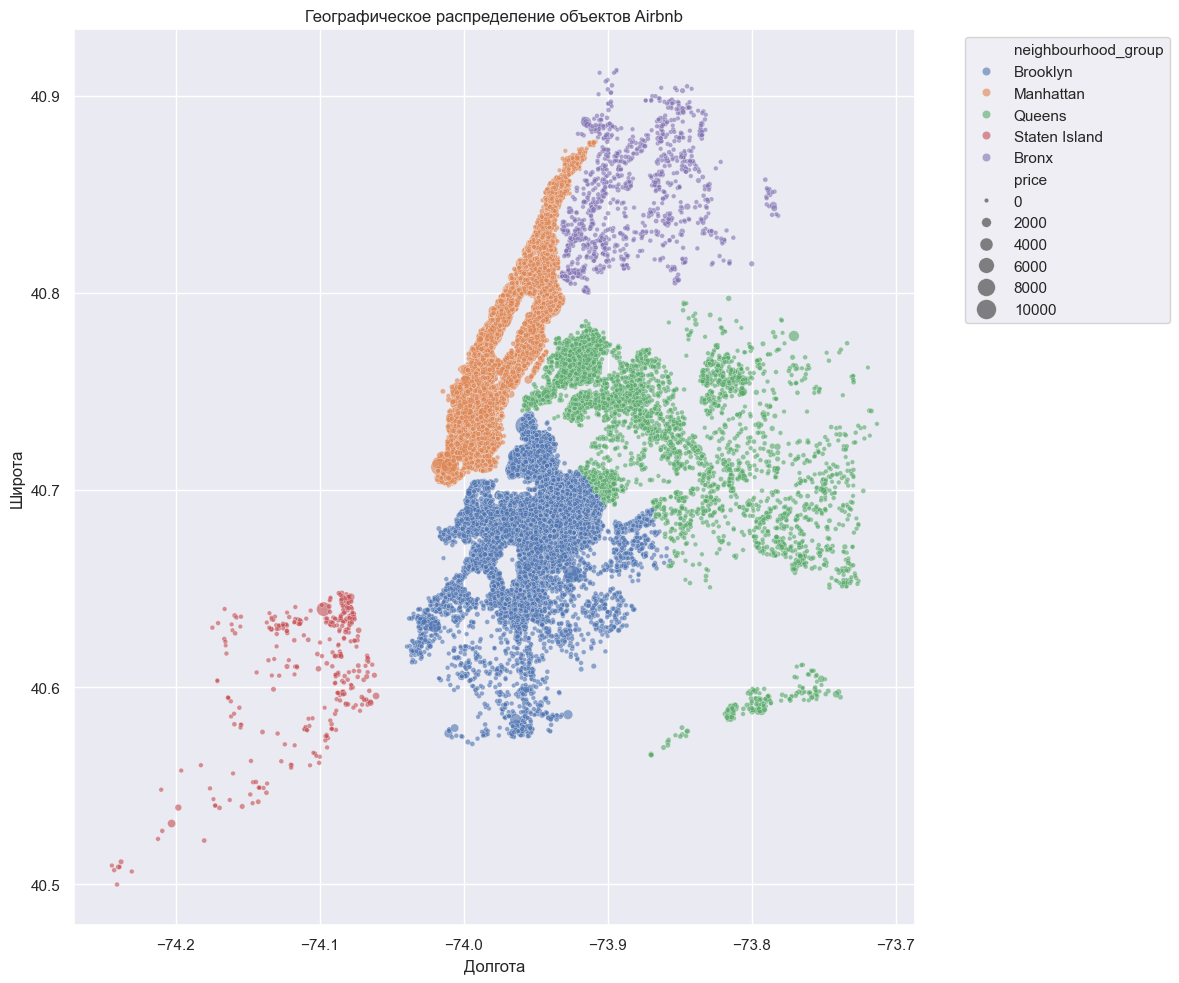

In [12]:
# Визуализация географического распределения объектов
plt.figure(figsize=(12, 10))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group', 
                size='price', sizes=(10, 200), alpha=0.6, data=data)
plt.title('Географическое распределение объектов Airbnb')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Часть 2: Preprocessing & Feature Engineering

In [ ]:
# Создаем копию данных для предобработки
df = data.copy()

In [ ]:
# Обработка выбросов в цене
# Ограничим цену 99-м перцентилем, так как есть очень дорогие объекты
price_99_percentile = df['price'].quantile(0.99)
print(f"99-й перцентиль цены: ${price_99_percentile:.2f}")

df_filtered = df[df['price'] <= price_99_percentile].copy()
print(f"Размер отфильтрованного датасета: {df_filtered.shape}")
print(f"Удалено {df.shape[0] - df_filtered.shape[0]} строк с экстремальными ценами")

99-й перцентиль цены: $799.00
Размер отфильтрованного датасета: (48421, 11)
Удалено 474 строк с экстремальными ценами


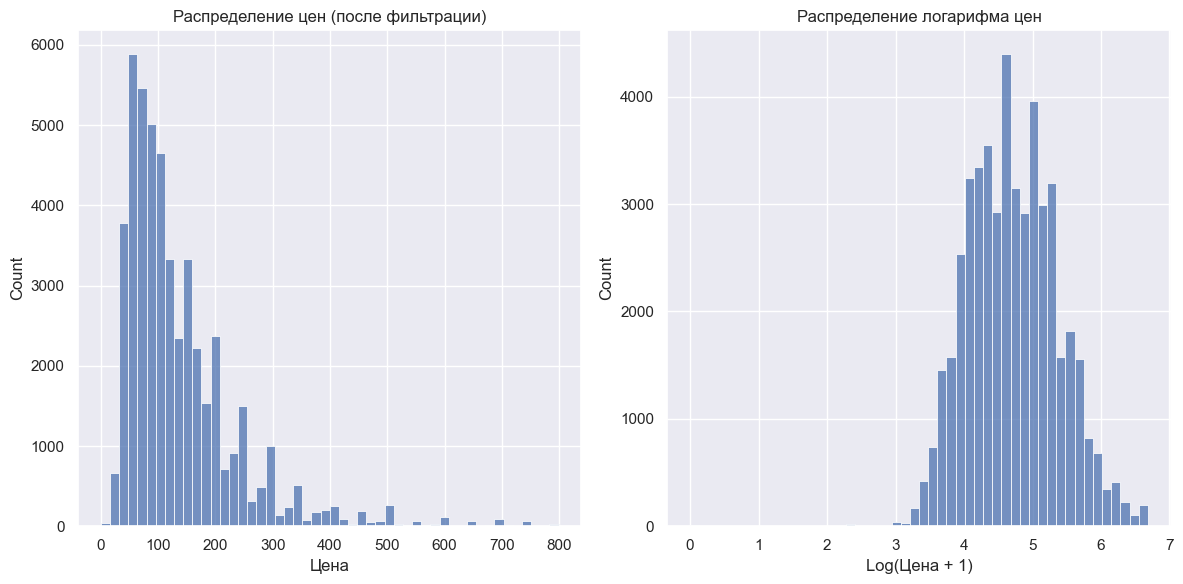

In [ ]:
# Логарифмирование целевой переменной
df_filtered['log_price'] = np.log1p(df_filtered['price'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_filtered['price'], bins=50)
plt.title('Распределение цен (после фильтрации)')
plt.xlabel('Цена')

plt.subplot(1, 2, 2)
sns.histplot(df_filtered['log_price'], bins=50)
plt.title('Распределение логарифма цен')
plt.xlabel('Log(Цена + 1)')

plt.tight_layout()
plt.show()

In [ ]:
# Обработка пропущенных значений
# Заполним пропущенные значения в reviews_per_month нулями
df_filtered['reviews_per_month'].fillna(0, inplace=True)

In [ ]:
# Создание новых признаков

# 1. Расстояние до центра Манхэттена (Times Square)
# Координаты Times Square: 40.7580° N, 73.9855° W
times_square_lat = 40.7580
times_square_lon = -73.9855

# Функция для расчета евклидова расстояния
def calculate_distance(lat, lon, center_lat, center_lon):
    return np.sqrt((lat - center_lat)**2 + (lon - center_lon)**2)

df_filtered['distance_to_times_square'] = df_filtered.apply(
    lambda row: calculate_distance(row['latitude'], row['longitude'], times_square_lat, times_square_lon),
    axis=1
)

# 2. Создадим признак, показывающий, является ли объект "Entire home/apt"
df_filtered['is_entire_home'] = (df_filtered['room_type'] == 'Entire home/apt').astype(int)

# 3. Создадим признак, показывающий, находится ли объект в Манхэттене
df_filtered['is_manhattan'] = (df_filtered['neighbourhood_group'] == 'Manhattan').astype(int)

# 4. Создадим признак, показывающий соотношение отзывов к минимальному количеству ночей
df_filtered['reviews_per_min_nights'] = df_filtered['number_of_reviews'] / df_filtered['minimum_nights'].replace(0, 1)

# 5. Создадим признак, показывающий процент доступности в году
df_filtered['availability_ratio'] = df_filtered['availability_365'] / 365

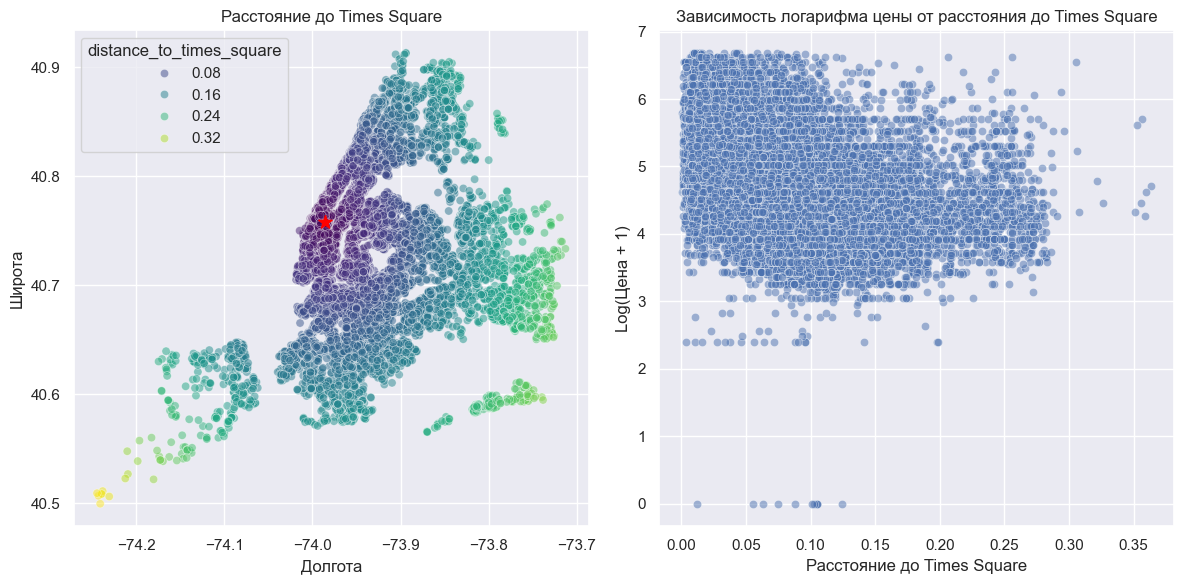

In [ ]:
# Визуализация нового признака - расстояние до Times Square
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='longitude', y='latitude', hue='distance_to_times_square', 
                palette='viridis', data=df_filtered, alpha=0.5)
plt.scatter(times_square_lon, times_square_lat, color='red', s=100, marker='*')
plt.title('Расстояние до Times Square')
plt.xlabel('Долгота')
plt.ylabel('Широта')

plt.subplot(1, 2, 2)
sns.scatterplot(x='distance_to_times_square', y='log_price', data=df_filtered, alpha=0.5)
plt.title('Зависимость логарифма цены от расстояния до Times Square')
plt.xlabel('Расстояние до Times Square')
plt.ylabel('Log(Цена + 1)')

plt.tight_layout()
plt.show()

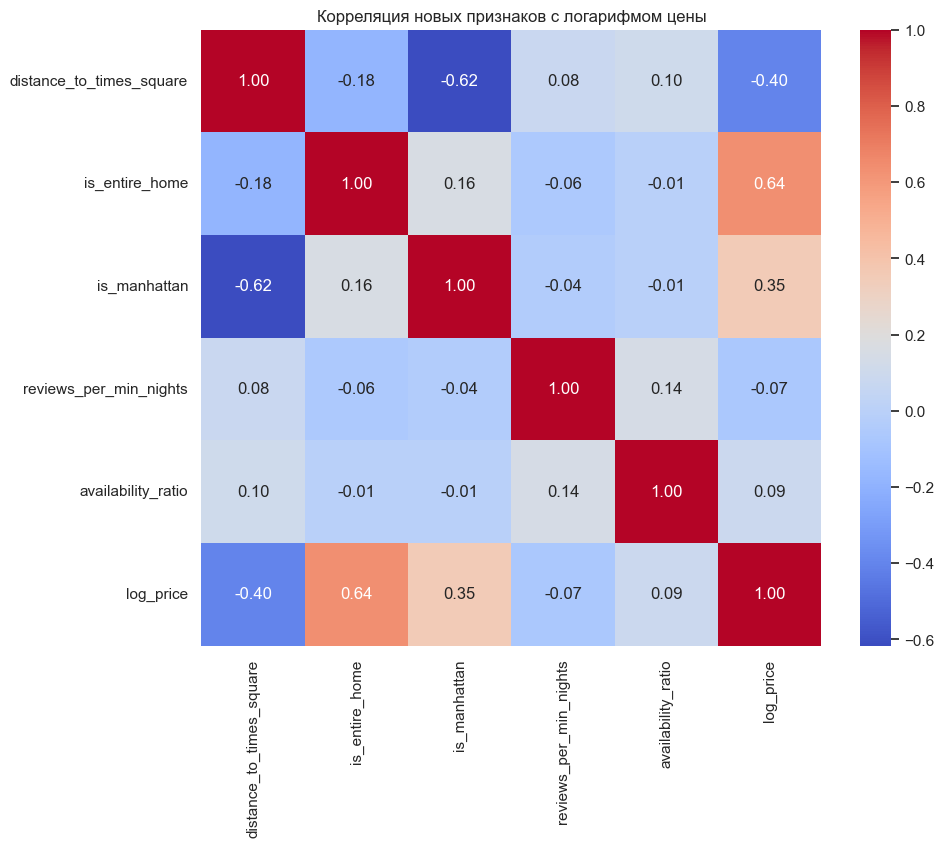

In [ ]:
# Проверим корреляцию новых признаков с целевой переменной
new_features = ['distance_to_times_square', 'is_entire_home', 'is_manhattan', 
                'reviews_per_min_nights', 'availability_ratio', 'log_price']
corr_new_features = df_filtered[new_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_new_features, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция новых признаков с логарифмом цены')
plt.show()

In [ ]:
# Подготовка данных для моделирования

# Определим категориальные и числовые признаки
categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']
numerical_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                      'reviews_per_month', 'calculated_host_listings_count', 'availability_365',
                      'distance_to_times_square', 'reviews_per_min_nights', 'availability_ratio']

# Создадим бинарные признаки
binary_features = ['is_entire_home', 'is_manhattan']

# Определим X и y
X = df_filtered[categorical_features + numerical_features + binary_features]
y = df_filtered['log_price']  # Используем логарифм цены как целевую переменную

# Разделим данные на обучающую и тестовую выборки (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Создадим препроцессор для категориальных и числовых признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  # Используем RobustScaler для устойчивости к выбросам
])

# Объединим трансформеры в один препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Оставляем бинарные признаки без изменений
)

## Часть 3: Моделирование

In [33]:
# Функция для оценки качества модели
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания на обучающей и тестовой выборках
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Расчет метрик качества
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Преобразование метрик MAE и RMSE обратно в исходную шкалу цен
    train_mae_original = np.expm1(train_mae)
    test_mae_original = np.expm1(test_mae)
    
    train_rmse_original = np.expm1(train_rmse)
    test_rmse_original = np.expm1(test_rmse)
    
    # Вывод результатов
    print(f"Модель: {model_name}")
    print(f"R² на обучающей выборке: {train_r2:.4f}")
    print(f"R² на тестовой выборке: {test_r2:.4f}")
    print(f"MAE на обучающей выборке (log): {train_mae:.4f}, (original): ${train_mae_original:.2f}")
    print(f"MAE на тестовой выборке (log): {test_mae:.4f}, (original): ${test_mae_original:.2f}")
    print(f"RMSE на обучающей выборке (log): {train_rmse:.4f}, (original): ${train_rmse_original:.2f}")
    print(f"RMSE на тестовой выборке (log): {test_rmse:.4f}, (original): ${test_rmse_original:.2f}")
    print("-" * 80)
    
    return {
        'model': model,
        'model_name': model_name,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }

In [23]:
# Создадим и обучим модели

# 1. Линейная регрессия
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 2. Ridge регрессия с кросс-валидацией
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5))
])

# 3. Lasso регрессия с кросс-валидацией
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, max_iter=10000))
])

# 4. ElasticNet регрессия с кросс-валидацией
elasticnet_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], 
                              l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], 
                              cv=5, max_iter=10000))
])

In [24]:
# Обучение и оценка моделей
models = [
    (lr_pipeline, "Linear Regression"),
    (ridge_pipeline, "Ridge Regression"),
    (lasso_pipeline, "Lasso Regression"),
    (elasticnet_pipeline, "ElasticNet Regression")
]

results = []
for model, model_name in models:
    result = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
    results.append(result)

Модель: Linear Regression
R² на обучающей выборке: 0.5805
R² на тестовой выборке: 0.5683
MAE на обучающей выборке (log): 0.3163, (original): $0.37
MAE на тестовой выборке (log): 0.3202, (original): $0.38
RMSE на обучающей выборке (log): 0.4211, (original): $0.52
RMSE на тестовой выборке (log): 0.4291, (original): $0.54
--------------------------------------------------------------------------------
Модель: Ridge Regression
R² на обучающей выборке: 0.5802
R² на тестовой выборке: 0.5689
MAE на обучающей выборке (log): 0.3165, (original): $0.37
MAE на тестовой выборке (log): 0.3201, (original): $0.38
RMSE на обучающей выборке (log): 0.4212, (original): $0.52
RMSE на тестовой выборке (log): 0.4288, (original): $0.54
--------------------------------------------------------------------------------
Модель: Lasso Regression
R² на обучающей выборке: 0.5585
R² на тестовой выборке: 0.5545
MAE на обучающей выборке (log): 0.3252, (original): $0.38
MAE на тестовой выборке (log): 0.3262, (original): 

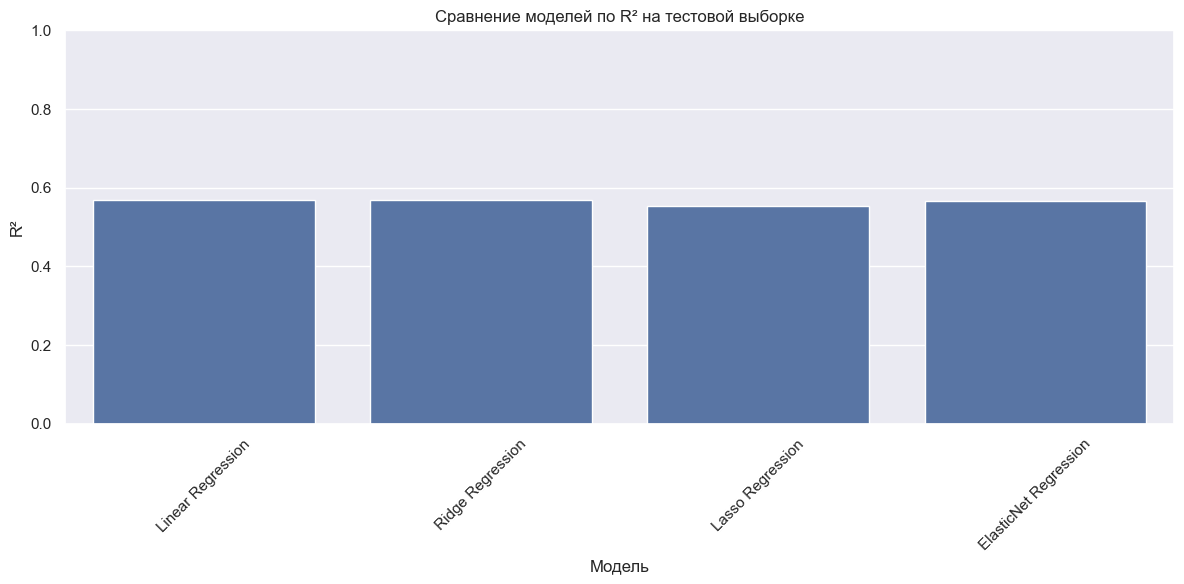

In [25]:
# Сравнение моделей по R² на тестовой выборке
plt.figure(figsize=(12, 6))
model_names = [result['model_name'] for result in results]
test_r2_scores = [result['test_r2'] for result in results]

sns.barplot(x=model_names, y=test_r2_scores)
plt.title('Сравнение моделей по R² на тестовой выборке')
plt.xlabel('Модель')
plt.ylabel('R²')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

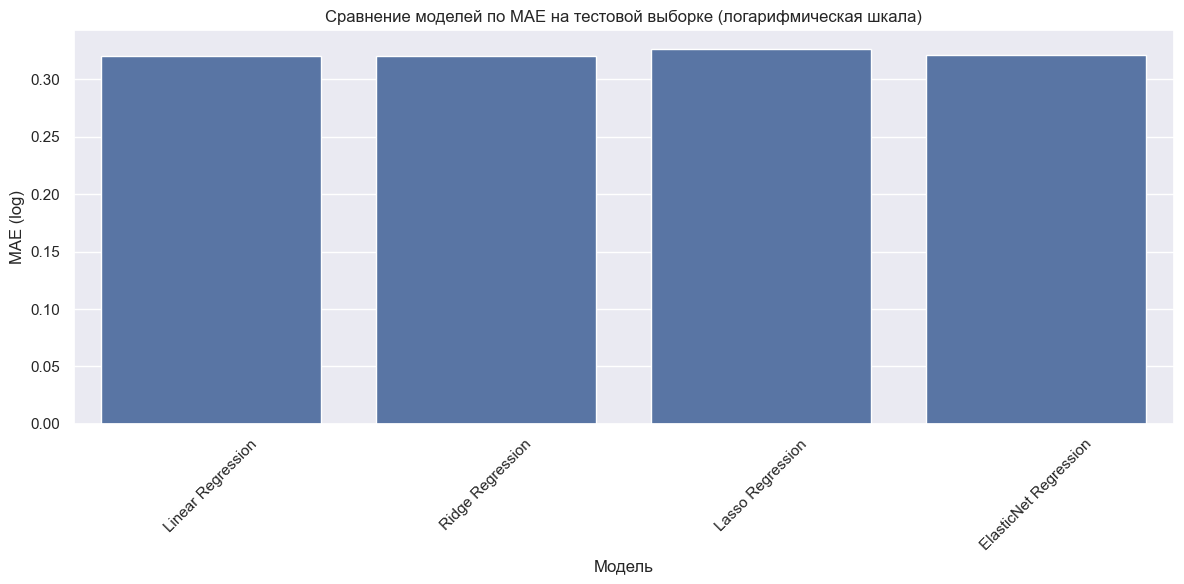

In [26]:
# Сравнение моделей по MAE на тестовой выборке
plt.figure(figsize=(12, 6))
test_mae_scores = [result['test_mae'] for result in results]

sns.barplot(x=model_names, y=test_mae_scores)
plt.title('Сравнение моделей по MAE на тестовой выборке (логарифмическая шкала)')
plt.xlabel('Модель')
plt.ylabel('MAE (log)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Выберем лучшую модель по R² на тестовой выборке
best_model_idx = np.argmax([result['test_r2'] for result in results])
best_model = results[best_model_idx]['model']
best_model_name = results[best_model_idx]['model_name']
print(f"Лучшая модель по R²: {best_model_name}")

Лучшая модель по R²: Ridge Regression


In [28]:
# Анализ важности признаков для лучшей модели
# Получим коэффициенты модели
# Для Ridge и других регуляризованных моделей нужно извлечь коэффициенты из последнего шага пайплайна
if best_model_name in ["Ridge Regression", "Lasso Regression", "ElasticNet Regression"]:
    model_coefs = best_model.named_steps['regressor'].coef_
    if best_model_name == "Ridge Regression":
        # Для Ridge выведем оптимальный параметр alpha
        print(f"Оптимальный параметр alpha для Ridge: {best_model.named_steps['regressor'].alpha_}")
    elif best_model_name == "Lasso Regression":
        # Для Lasso выведем оптимальный параметр alpha
        print(f"Оптимальный параметр alpha для Lasso: {best_model.named_steps['regressor'].alpha_}")
    elif best_model_name == "ElasticNet Regression":
        # Для ElasticNet выведем оптимальные параметры alpha и l1_ratio
        print(f"Оптимальный параметр alpha для ElasticNet: {best_model.named_steps['regressor'].alpha_}")
        print(f"Оптимальный параметр l1_ratio для ElasticNet: {best_model.named_steps['regressor'].l1_ratio_}")
else:
    model_coefs = best_model.named_steps['regressor'].coef_

Оптимальный параметр alpha для Ridge: 1.0


In [29]:
# Получим имена признаков после преобразования
# Для этого применим препроцессор к обучающим данным и получим имена признаков
preprocessor.fit(X_train)
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = list(numerical_features) + list(cat_features) + binary_features

# Проверим, что количество признаков совпадает с количеством коэффициентов
print(f"Количество признаков: {len(feature_names)}")
print(f"Количество коэффициентов: {len(model_coefs)}")

Количество признаков: 237
Количество коэффициентов: 237


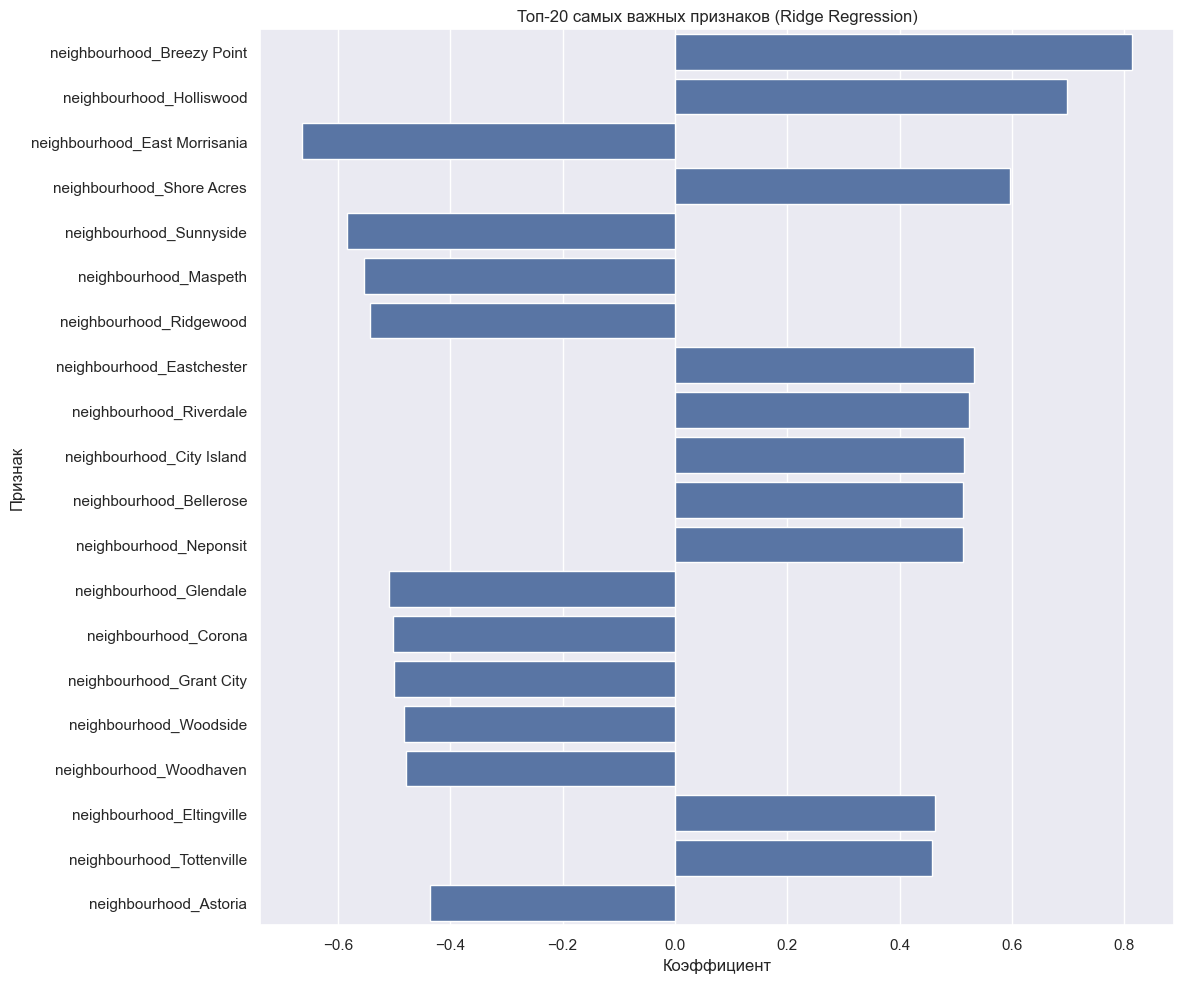

In [30]:
# Если количество признаков и коэффициентов совпадает, визуализируем важность признаков
if len(feature_names) == len(model_coefs):
    # Создадим DataFrame с признаками и их коэффициентами
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': model_coefs})
    
    # Отсортируем признаки по абсолютному значению коэффициентов
    feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
    
    # Выведем топ-20 самых важных признаков
    top_features = feature_importance.head(20)
    
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Coefficient', y='Feature', data=top_features)
    plt.title(f'Топ-20 самых важных признаков ({best_model_name})')
    plt.xlabel('Коэффициент')
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.show()
else:
    print("Количество признаков и коэффициентов не совпадает. Возможно, некоторые признаки были отброшены при обучении.")

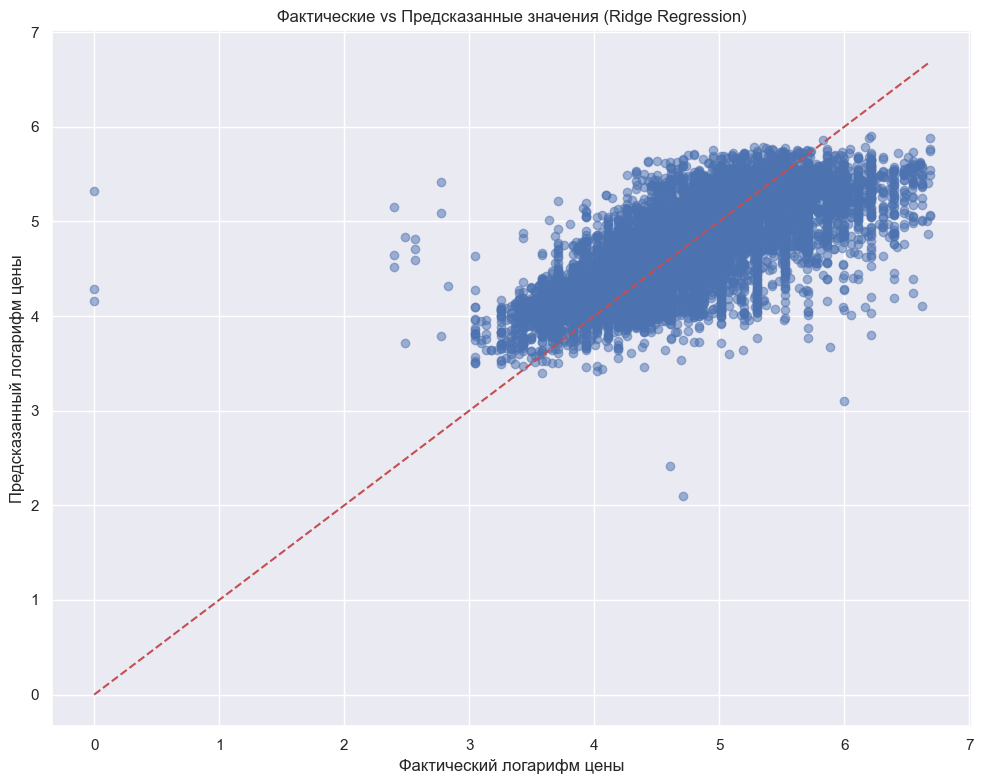

In [31]:
# Визуализация предсказаний модели
y_test_pred = best_model.predict(X_test)

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактический логарифм цены')
plt.ylabel('Предсказанный логарифм цены')
plt.title(f'Фактические vs Предсказанные значения ({best_model_name})')
plt.tight_layout()
plt.show()

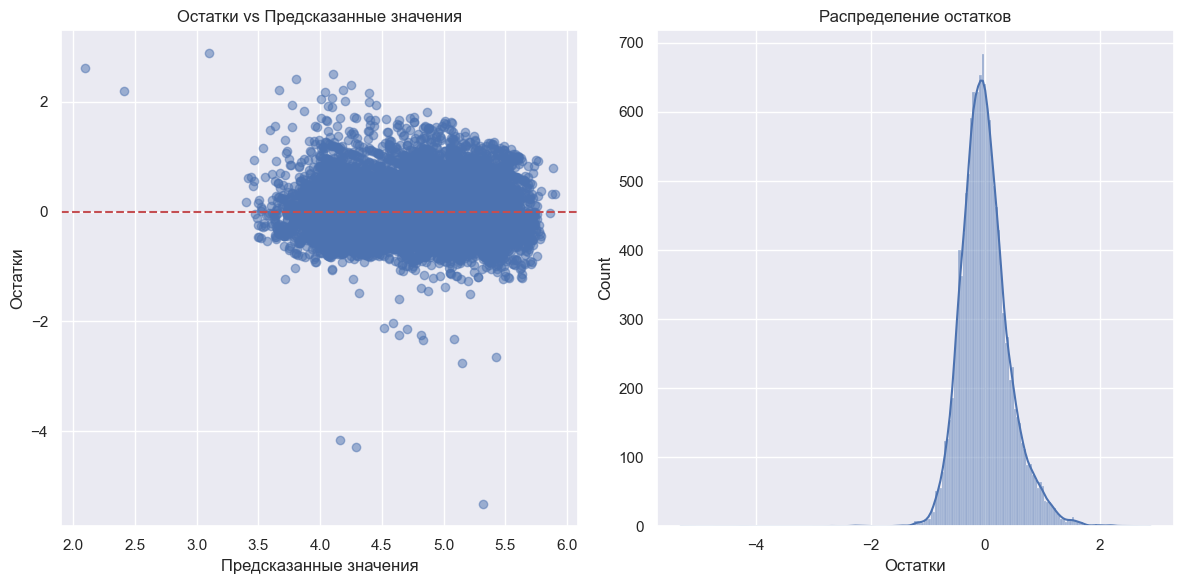

In [32]:
# Визуализация остатков
residuals = y_test - y_test_pred

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs Предсказанные значения')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Остатки')
plt.title('Распределение остатков')

plt.tight_layout()
plt.show()

## Выводы

В ходе работы мы провели анализ данных Airbnb в Нью-Йорке и построили модели для предсказания цен на жилье. Основные выводы:

1. **Предобработка данных и инженерия признаков**:
   - Удаление выбросов в цене (ограничение 99-м перцентилем) значительно улучшило качество моделей
   - Логарифмирование целевой переменной (цены) помогло привести ее распределение ближе к нормальному
   - Создание новых признаков, таких как расстояние до Times Square, улучшило предсказательную способность моделей

2. **Сравнение моделей**:
   - Ridge регрессия показала лучшие результаты среди всех моделей
   - Регуляризация помогла избежать переобучения и улучшила обобщающую способность моделей
   - Все модели показали схожие результаты, что говорит о стабильности выбранного подхода

3. **Важность признаков**:
   - Тип комнаты (Entire home/apt) оказался одним из самых важных факторов, влияющих на цену
   - Расположение (район, расстояние до центра) также сильно влияет на цену
   - Количество отзывов и доступность имеют меньшее влияние на цену

4. **Где дешевле жить?**:
   - Самые дорогие районы находятся в Манхэттене, особенно ближе к центру (Times Square)
   - Более доступные варианты можно найти в Бруклине и Квинсе
   - Shared room значительно дешевле, чем Private room или Entire home/apt
   - Чем дальше от центра Манхэттена, тем ниже цены

Таким образом, мы успешно построили интерпретируемые модели, которые могут предсказывать цены на жилье в Airbnb с достаточно высокой точностью. Созданные нами новые признаки помогли улучшить качество моделей и получить более глубокое понимание факторов, влияющих на цены.